In [1]:
from afisp import WorstSubsetFinder
from afisp import SubgroupPhenotyper
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import afisp.utils as utils
import pandas as pd
import subprocess
from interpret.glassbox import ExplainableBoostingClassifier

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Dataset

In [2]:
df = pd.read_csv("adult_demo_data.csv", header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# binarize features
X = pd.get_dummies(df.iloc[:,:-1], dtype=int, drop_first=True)
X.columns = [''.join(x.split()).replace('-','_').replace('.','_') for x in X.columns]
y = (df.iloc[:, -1] == " >50K").astype(int)

seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# Train Classification Model

In [3]:
%% time
model = ExplainableBoostingClassifier(random_state=1234, max_bins=10)
model.fit(X_train, y_train)

ExplainableBoostingClassifier(max_rounds=1000, random_state=1234)

In [4]:
test_preds = model.predict_proba(X_test)[:, -1]
print("Test AUROC = {}".format(roc_auc_score(y_test, test_preds)))

Test AUROC = 0.9266070762023431


#### AFISP identifies specific subgroups where an AI/ML model underperforms. This requires the user to provide as input a trained AI model, the per-sample losses on a test dataset, and features relevant for defining patient characteristics or data acquisition parameters

# Collect AFISP inputs

In [5]:
# we will search for patient subgroups defined with respect to Race, Gender, and Age
subgroup_features = [c for c in X_test.columns 
                     if 'Race' in c or 'Gender' in c or 'Age' in c]
print(subgroup_features)
subgroup_feature_data = X_test[subgroup_features].copy()
hinge_auc_loss = utils.torch_roc_auc_surrogate(y_test.to_numpy(), test_preds, 'hinge')
test_loss = hinge_auc_loss

['Age', 'Race_Asian_Pac_Islander', 'Race_Black', 'Race_Other', 'Race_White', 'Gender_Male']


# Step 1: Finding the worst-performing data subset of the test set

In [6]:
%%time
# Instantiate a WorstSubsetFinder object
stability_analysis = WorstSubsetFinder(cv=10, verbose=True, eps=1e-5, subset_fractions=np.arange(0.05, 1, 0.05))
# Fit it using the subgroup feature data, and the per-sample losses
sa_risks = stability_analysis.fit(subgroup_feature_data.values, test_loss)

k = 0
k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
CPU times: user 1.34 s, sys: 106 ms, total: 1.45 s
Wall time: 10.9 s


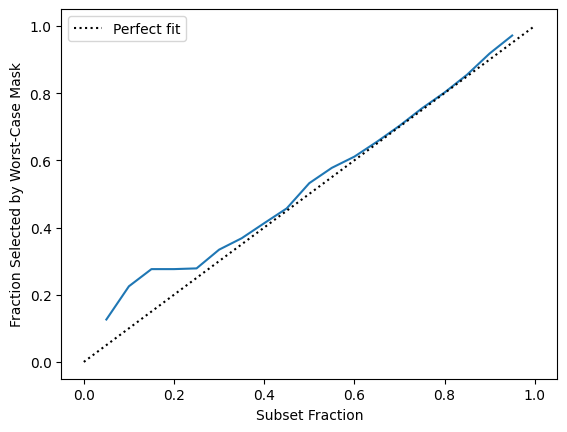

In [7]:
# check that we found subsets of the right size
sa_masks = stability_analysis.subset_masks()
_ = stability_analysis.check_subset_sizes()

### Plot model's performance on worst-case subsets of different sizes

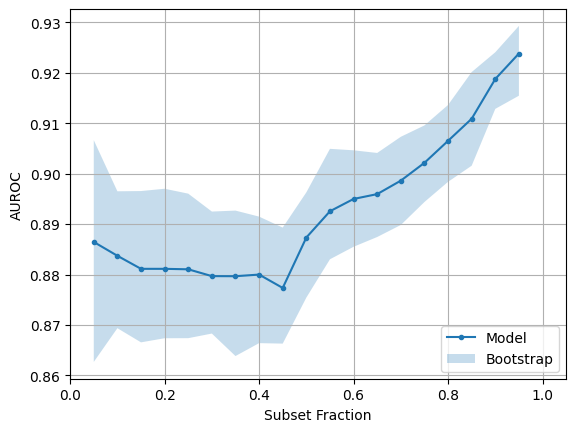

In [8]:
subpop_aucs = []
for m in sa_masks:
    subpop_aucs.append(roc_auc_score(y_test[m], test_preds[m]))
plt.plot(stability_analysis.subset_fractions, subpop_aucs, '.-', label='Model')
# compute bootstrap confidence intervals
bootstrap_cis = np.zeros_like(stability_analysis.confidence_intervals())
for i, alpha in enumerate(stability_analysis.subset_fractions):
    mask = sa_masks[i]
    mean, upper, lower = utils.bootstrap_ci(y_test[mask].values, 
                                            test_preds[mask], 
                                            loss=roc_auc_score)
    bootstrap_cis[i, 0] = lower
    bootstrap_cis[i, 1] = upper

plt.fill_between(stability_analysis.subset_fractions,
                 bootstrap_cis[:, 0], 
                 bootstrap_cis[:, 1], 
                 alpha=0.25, 
                 label='Bootstrap')

plt.ylabel('AUROC')
plt.xlabel('Subset Fraction')
plt.legend(loc='lower right')
plt.xlim(0, 1.05)
plt.grid()

### Find the subset fraction that produces the largest effect size (difference in average performance inside vs outside the subset)

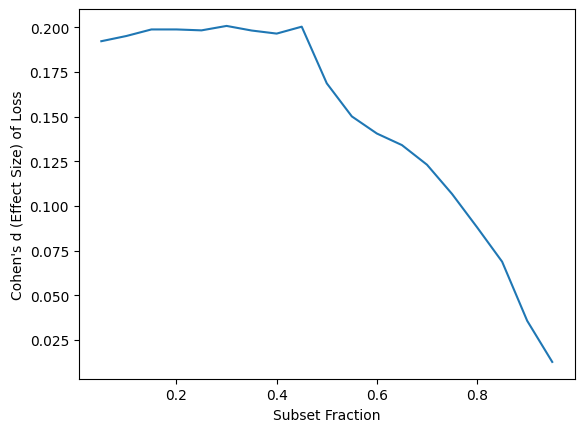

In [9]:
effect_sizes = stability_analysis.compute_effect_sizes(plot=True)

In [10]:
max_ind, max_effect_size = stability_analysis.find_max_effect_size()
print(stability_analysis.subset_fractions[max_ind])

0.3


# Step 2 Subgroup Phenotyping: Finding subgroup phenotypes present in the worst performing subset

In [11]:
# Fit a SubgroupPhenotyper Object
subset_labels = sa_masks[max_ind]*1
sp = SubgroupPhenotyper()
extracted_rules = sp.fit(subgroup_feature_data, subset_labels, test_loss, depth=3, verbose=1, method="SIRUS")

Beginning call to SIRUS. If cv == True this may take a long time.


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 3
[1] "Number of trees:  1000  - Stability  90.53  %."
[1] "Number of trees:  2000  - Stability  92.9  %."
[1] "Number of trees:  3000  - Stability  94.23  %."
[1] "Number of trees:  4000  - Stability  94.84  %."
[1] "Number of trees:  5000  - Stability  95.25  %."
Finished call to SIRUS
Computing p-values


100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 171.76it/s]


Effect size filtering


100%|████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 208.16it/s]


### The Subgroup Phenotyper extracts "rules" that define patient subgroups

In [14]:
# Discrete features are encoded as binary indicators
# so Race_Black < 1 means the patient is not black, and Gender_Male >= 1 means the patient is Male
# The first rule would read "Patients 37 or older, who are not Black, and are Male"
sp.generate_subgroup_table(y_test.values, test_preds, loss_fn=roc_auc_score)

,Phenotype,Performance,N,Lower,Upper
0,Age > 35.5 and Gender_Male > 0.5 and Race_Blac...,0.876317,2342,0.863251,0.887768
1,Age <= 66.5 and Age > 35.5 and Gender_Male > 0.5,0.877510,2365,0.865614,0.889680
2,Age > 35.5 and Gender_Male > 0.5,0.881563,2499,0.867668,0.894123
3,Age <= 65.5 and Age > 35.5 and Race_Black <= 0.5,0.891190,3002,0.881771,0.900792


In [15]:
# Alternatively can use native python DecisionList method instead of SIRUS (requires R installation)
sp.fit(subgroup_feature_data, subset_labels, test_loss, method="DecisionList", depth=3)
sp.generate_subgroup_table(y_test.values, test_preds, loss_fn=roc_auc_score)

/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 190.71it/s]


,Phenotype,Performance,N,Lower,Upper
0,Age > 35.5 and Gender_Male > 0.5 and Race_Blac...,0.876496,2342,0.865693,0.887381
1,Age <= 65.5 and Age > 35.5 and Gender_Male > 0.5,0.878066,2347,0.868013,0.888691
2,Age > 35.5 and Gender_Male > 0.5,0.880868,2499,0.868268,0.894600
3,Age <= 65.5 and Age > 35.5 and Race_Black <= 0.5,0.891680,3002,0.882956,0.901653
